Running analysis for medA...


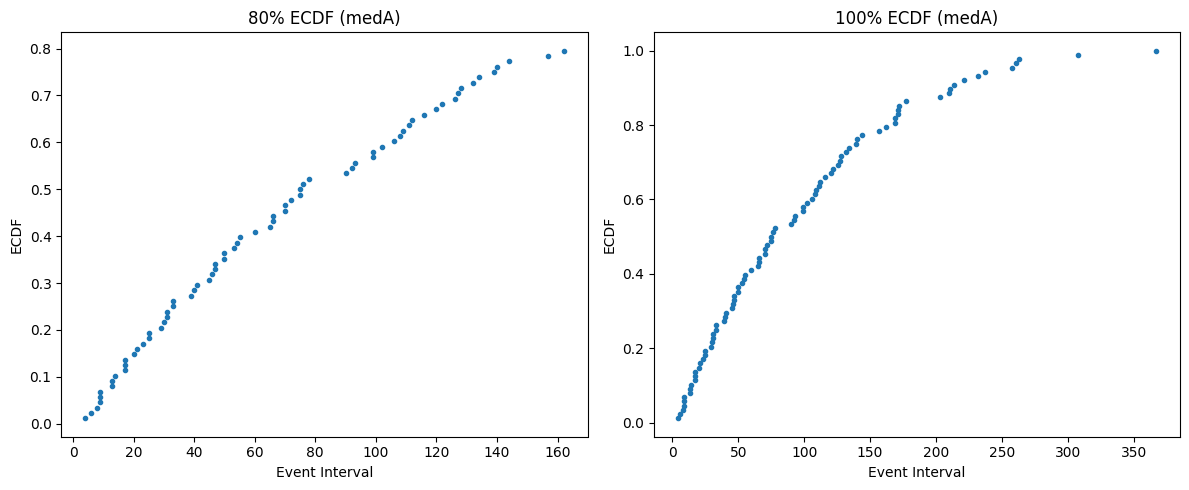

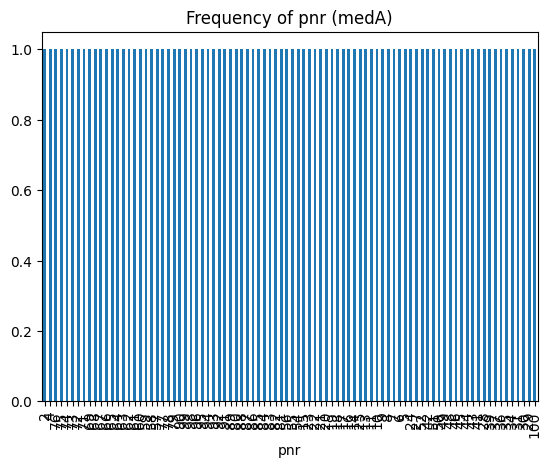

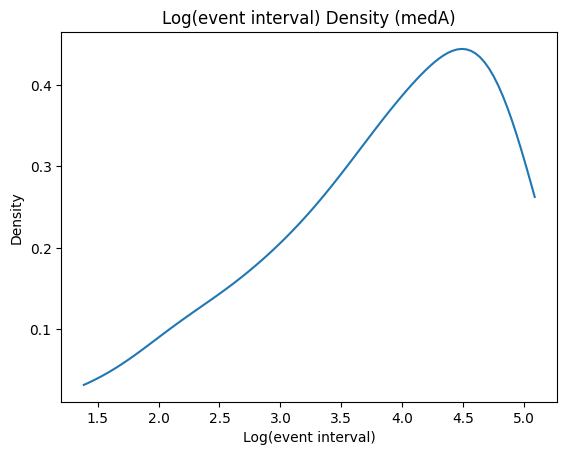

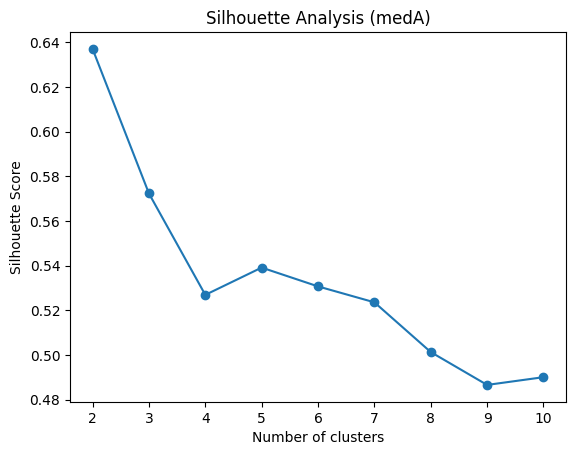

Running analysis for medB...


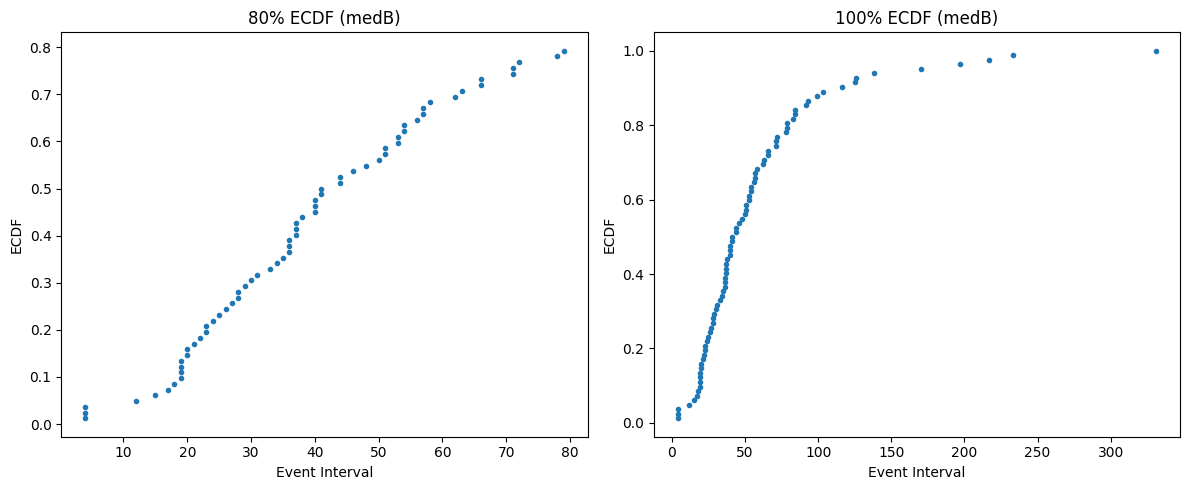

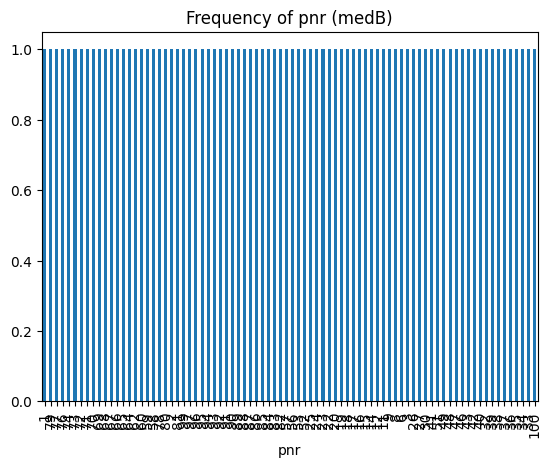

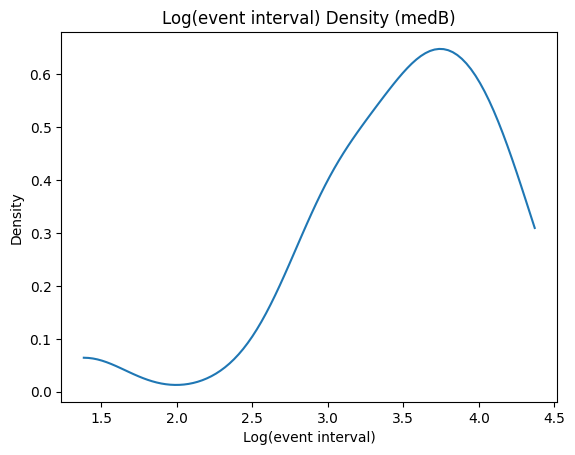

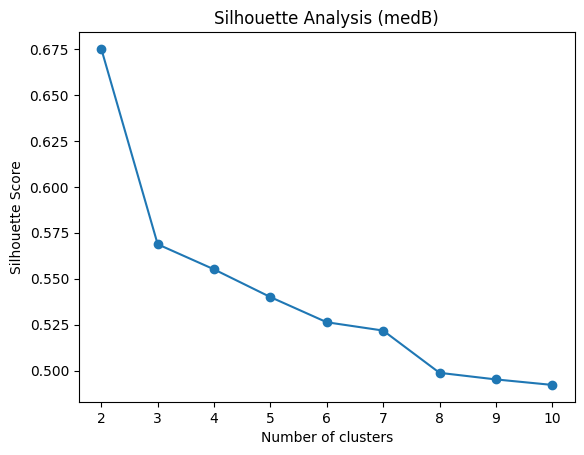

Creating boxplots...


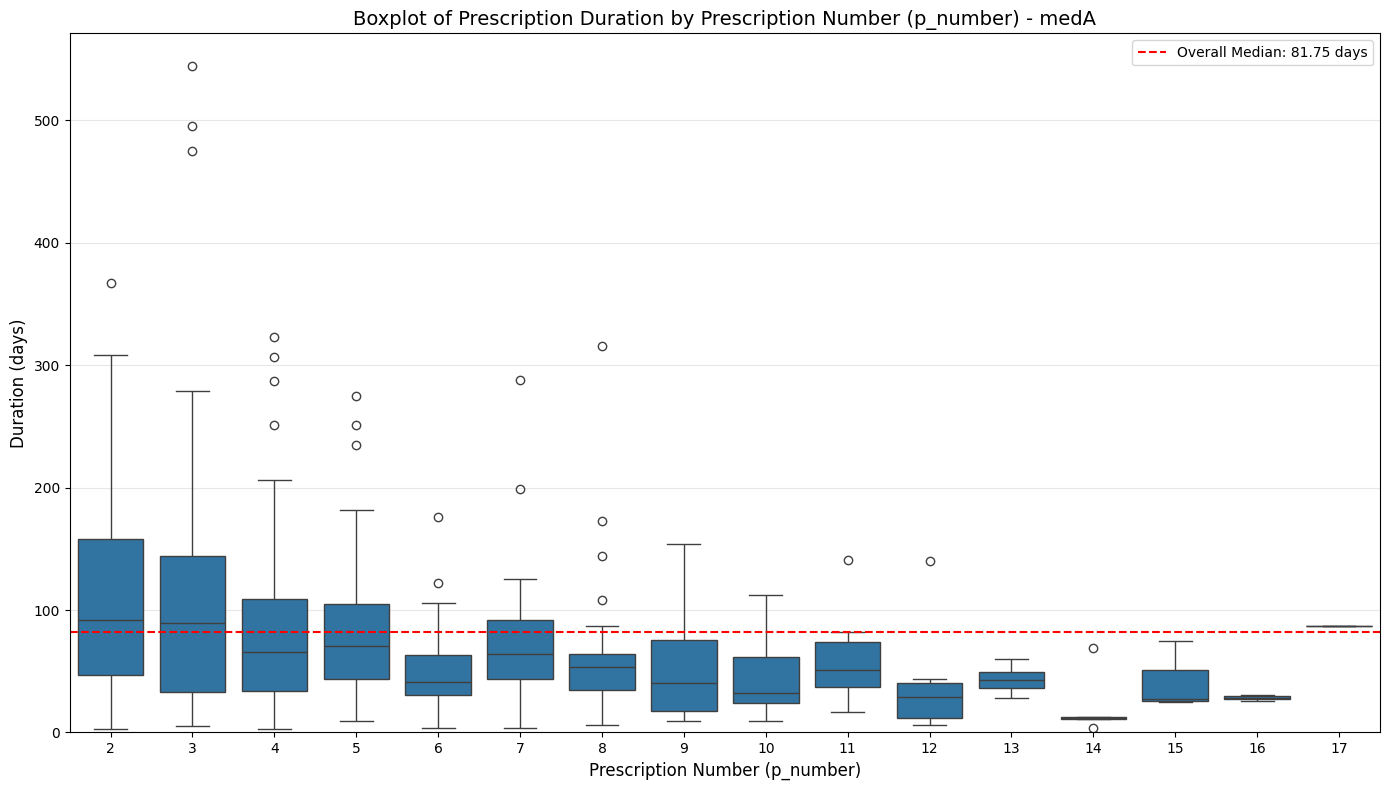

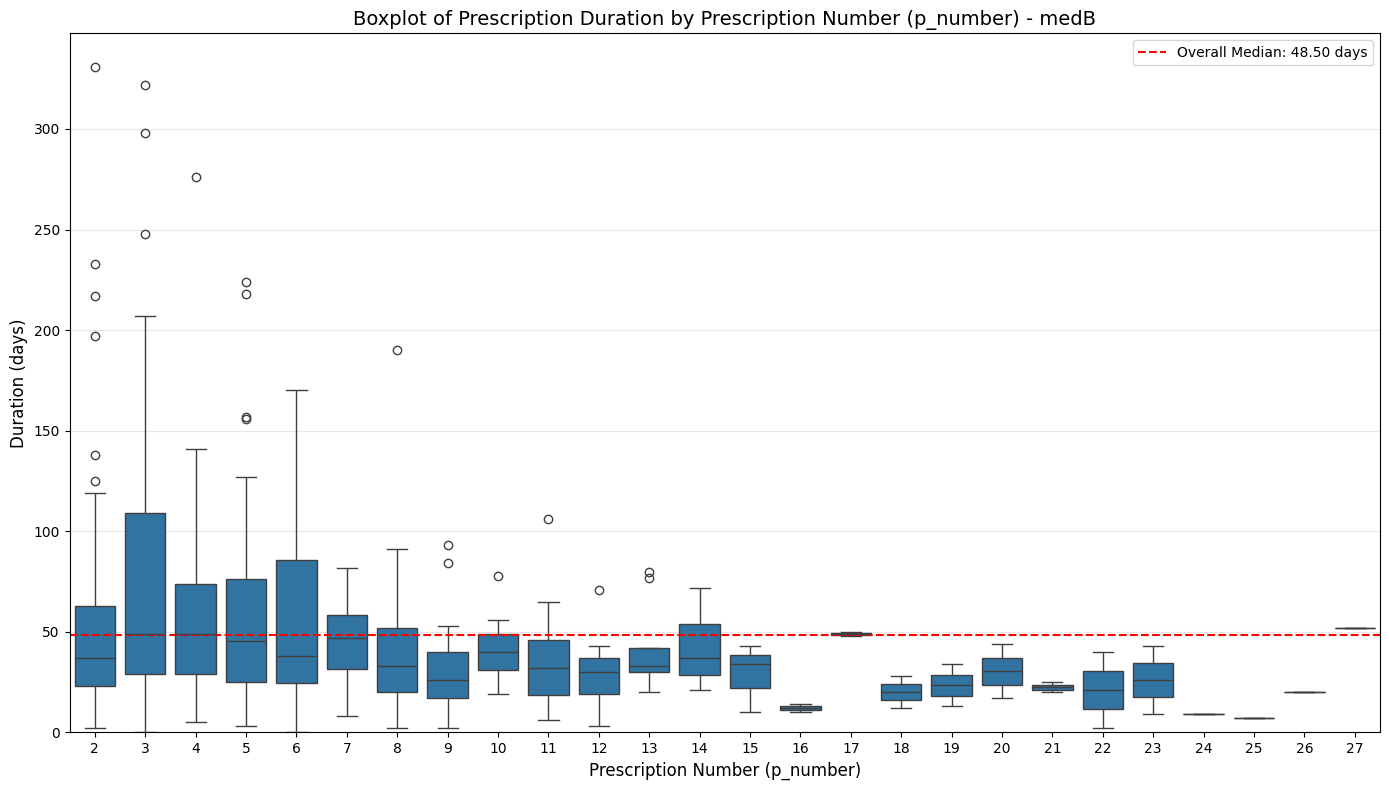

Analysis complete!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde

# Set seed for reproducibility
np.random.seed(1234)

def load_data(file_path='med_events.csv'):
    """
    Load and preprocess the medication events data
    """
    # Read the CSV file
    med_events = pd.read_csv(file_path)
    
    # Create a tidy dataset with the expected column names
    tidy = med_events.copy()
    tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    
    # Convert 'eksd' to datetime 
    tidy['eksd'] = pd.to_datetime(tidy['eksd'])
    
    return tidy

def See(arg1):
    """
    Analyze medication adherence patterns
    
    Parameters:
    arg1 (str): The ATC code to analyze (e.g., "medA")
    
    Returns:
    DataFrame: Processed data with adherence metrics
    """
    # Filter dataset where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Take a random sequence of consecutive prescriptions in the dataset
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Arrange by pnr and eksd, then compute the previous eksd per pnr
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA in prev_eksd
    Drug_see_p1 = Drug_see_p1[~Drug_see_p1['prev_eksd'].isna()].copy()
    
    # For each pnr, randomly sample one row
    groups = []
    for name, group in Drug_see_p1.groupby('pnr'):
        groups.append(group.sample(1, random_state=1234))
    Drug_see_p1 = pd.concat(groups).reset_index(drop=True)
    
    # Keep only the needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']].copy()
    
    # Compute event interval (in days)
    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # ---- Build ECDF using only positive event intervals ----
    valid_intervals = Drug_see_p1.loc[Drug_see_p1['event_interval'] > 0, 'event_interval']
    if len(valid_intervals) == 0:
        raise ValueError("No positive event intervals found.")
    sorted_vals = np.sort(valid_intervals.values)
    n = len(sorted_vals)
    ecdf_y = np.arange(1, n + 1) / n
    dfper = pd.DataFrame({'x': sorted_vals, 'y': ecdf_y})
    
    # Retain the lower 80% of the ECDF (i.e. where y <= 0.8)
    dfper_80 = dfper[dfper['y'] <= 0.8].copy()
    ni = dfper_80['x'].max() if not dfper_80.empty else dfper['x'].max()
    
    # Plot the 80% ECDF and the full (100%) ECDF side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axs[0].set_title(f"80% ECDF ({arg1})")
    axs[0].set_xlabel("Event Interval")
    axs[0].set_ylabel("ECDF")
    
    axs[1].plot(sorted_vals, ecdf_y, marker='.', linestyle='none')
    axs[1].set_title(f"100% ECDF ({arg1})")
    axs[1].set_xlabel("Event Interval")
    axs[1].set_ylabel("ECDF")
    plt.tight_layout()
    plt.show()
    
    # Plot frequency of 'pnr'
    m1 = Drug_see_p1['pnr'].value_counts()
    m1.plot(kind='bar', title=f"Frequency of pnr ({arg1})")
    plt.show()
    
    # --- Filter rows with event_interval <= ni ---
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni].copy()
    
    # Filter out event_interval values that are zero or negative to avoid log(0) issues
    Drug_see_p2 = Drug_see_p2[Drug_see_p2['event_interval'] > 0].copy()
    
    # --- Density estimation of log(event_interval) ---
    log_vals = np.log(Drug_see_p2['event_interval'].values)
    density = gaussian_kde(log_vals)
    x_dens = np.linspace(log_vals.min(), log_vals.max(), 100)
    y_dens = density(x_dens)
    
    plt.figure()
    plt.plot(x_dens, y_dens)
    plt.title(f"Log(event interval) Density ({arg1})")
    plt.xlabel("Log(event interval)")
    plt.ylabel("Density")
    plt.show()
    
    # Create a DataFrame from the density estimation and scale it
    a_df = pd.DataFrame({'x': x_dens, 'y': y_dens})
    a_scaled = scale(a_df)  # returns a NumPy array
    
    # --- Silhouette Analysis to determine optimal number of clusters ---
    silhouette_scores = {}
    # Try number of clusters from 2 to min(10, number of samples)
    for k in range(2, min(10, len(a_scaled)) + 1):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        max_cluster = max(silhouette_scores, key=silhouette_scores.get)
    else:
        max_cluster = 1
    
    # Optionally plot silhouette scores
    plt.figure()
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title(f"Silhouette Analysis ({arg1})")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    # --- K-means Clustering on dfper['x'] ---
    X_cluster = dfper['x'].values.reshape(-1, 1)
    kmeans_final = KMeans(n_clusters=max_cluster, random_state=1234)
    cluster_labels = kmeans_final.fit_predict(X_cluster)
    dfper['cluster'] = cluster_labels
    
    # Compute summary statistics (min, max, median) on log(x) by cluster
    dfper['log_x'] = np.log(dfper['x'])
    cluster_stats = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    # Exponentiate to revert from log scale
    cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
    cluster_stats['Median'] = np.exp(cluster_stats['median'])
    # Retain only clusters with Median > 0
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0].copy()
    
    # --- Cross join Drug_see_p1 with cluster_stats ---
    Drug_see_p1['_key'] = 1
    cluster_stats['_key'] = 1
    results = pd.merge(Drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)
    # Assign Final_cluster where event_interval falls within the cluster's [Minimum, Maximum]
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & (results['event_interval'] <= results['Maximum']),
        results['cluster'], np.nan
    )
    results = results.dropna(subset=['Final_cluster']).copy()
    # Keep only the needed columns and rename for consistency
    results = results[['pnr', 'Median', 'cluster']].rename(columns={'cluster': 'Cluster'})
    
    # Determine the most frequent cluster from results
    cluster_freq = results['Cluster'].value_counts()
    if not cluster_freq.empty:
        most_freq_cluster = cluster_freq.idxmax()
        t1 = cluster_stats[cluster_stats['cluster'] == most_freq_cluster][['Median']].iloc[0]
    else:
        t1 = pd.Series({'Median': np.nan})
    
    # Merge the results back into Drug_see_p1 by 'pnr'
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    # Fill missing Median with t1's Median and missing Cluster with 0
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'])
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(0)
    # Calculate test as the rounded difference between event_interval and Median
    Drug_see_p1['test'] = np.round(Drug_see_p1['event_interval'] - Drug_see_p1['Median'], 1)
    
    # Extract the columns of interest
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'Cluster']].copy()
    
    # --- Assign Duration ---
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = pd.to_numeric(Drug_see_p0['Median'])
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'])
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)
    
    return Drug_see_p0

def see_assumption(df, drug):
    """
    Create boxplots of prescription durations by prescription number
    
    Parameters:
    df (DataFrame): The medication data to analyze
    drug (str): Name of the medication (e.g., "medA")
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    # Arrange by pnr and eksd and compute the previous eksd
    df_sorted = df.sort_values(by=['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    
    # Create a sequential p_number per pnr
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    
    # Keep only rows with p_number >= 2
    Drug_see2 = df_sorted[df_sorted['p_number'] >= 2].copy()
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']].copy()
    
    # Compute Duration in days
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days.astype(float)
    
    # Convert p_number to a categorical variable
    Drug_see2['p_number'] = Drug_see2['p_number'].astype(str)
    
    # Calculate the median duration per pnr and then the overall median of these medians
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().median()
    
    # Plot a boxplot of Duration by p_number using seaborn
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.title(f"Boxplot of Prescription Duration by Prescription Number (p_number) - {drug}", fontsize=14)
    plt.xlabel("Prescription Number (p_number)", fontsize=12)
    plt.ylabel("Duration (days)", fontsize=12)
    
    # Add horizontal line for overall median
    plt.axhline(y=medians_of_medians, linestyle='--', color='red', 
                label=f"Overall Median: {medians_of_medians:.2f} days")
    plt.legend(loc='upper right')
    
    # Make sure y-axis starts from 0
    plt.ylim(bottom=0)
    
    # Add grid
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{drug}_boxplot.png')
    plt.show()
    
    return plt

def main():
    """
    Main function to run the analysis
    """
    # Load data
    global tidy  # Make tidy accessible to See function
    tidy = load_data()
    
    print("Running analysis for medA...")
    result_medA = See("medA")
    
    print("Running analysis for medB...")
    result_medB = See("medB")
    
    print("Creating boxplots...")
    see_assumption(result_medA, "medA")
    see_assumption(result_medB, "medB")
    
    print("Analysis complete!")

if __name__ == "__main__":
    main()